In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import ujipenchars2
from drawing import Drawing
from preprocessing import DrawingToBoxScaler, DrawingResampler
from dtw import dtw, rsi_dtw_distance_matrix_symmetric, dtw_distance_matrix_symmetric, dtw_distance_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from classifier_pickle import DTWClassifierPickle, RSIDTWClassifierPickle

In [2]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)
data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([drawing.label for drawing in data])

len(train), len(test)

(800, 400)

In [3]:
# Preprocessing
drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
data = drawing_scaler.transform(data)

drawing_resampler = DrawingResampler(40)
data = drawing_resampler.transform(data)

In [4]:
# Tenzor sa svim podacima
stacked_data = np.stack([np.vstack(drawing.strokes) for drawing in data])
# Matrica s DTW udaljenostima
DTW = dtw_distance_matrix_symmetric(stacked_data, stacked_data[train_idx])
# Matrica s RSIDTW udaljenostima
RSIDTW = rsi_dtw_distance_matrix_symmetric(stacked_data, stacked_data[train_idx], 10)

In [5]:
def knn_loocv(D, train_idx, test_idx, max_neighbors):
    n_neighbors = list(range(1, max_neighbors + 1))
    scores = []
    best_score = 0
    best_cls = None
    D = D[:]
    np.fill_diagonal(D, 2*np.max(D))
    for i in n_neighbors:
        cls = KNeighborsClassifier(n_neighbors=i, weights='uniform', algorithm='brute', metric='precomputed')
        cls.fit(DTW[np.ix_(train_idx, train_idx)], labels[train_idx])
        scores.append(cls.score(DTW[np.ix_(train_idx, train_idx)], labels[train_idx]))
        if scores[-1] > best_score:
            best_score = scores[-1]
            best_cls = cls
    return best_cls, best_cls.score(D[np.ix_(test_idx, train_idx)], labels[test_idx]), n_neighbors, scores

n_neighbors = 1
Točnost na test: 0.98


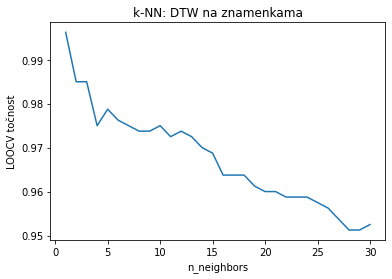

In [6]:
knn_dtw, test_score, n_neighbors, scores = knn_loocv(DTW, train_idx, test_idx, 30)

print('n_neighbors =', knn_dtw.get_params()['n_neighbors'])
print('Točnost na test:', test_score)

plt.plot(n_neighbors, scores)
plt.title('k-NN: DTW na znamenkama')
plt.xlabel('n_neighbors')
plt.ylabel('LOOCV točnost')
plt.show()

In [7]:
# Spremamo najbolji DTW model za znamenke
DTWClassifierPickle(
    stacked_train=stacked_data[train_idx],
    drawing_scaler=drawing_scaler,
    drawing_resampler=drawing_resampler,
    cls=knn_dtw,
).save('models/KNN-DTW.pickle')

n_neighbors = 1
Točnost na test: 0.9825


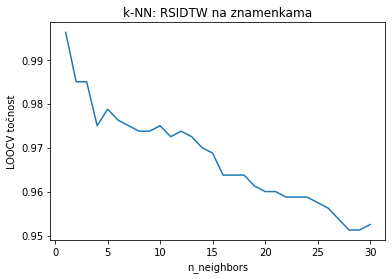

In [8]:
knn_rsidtw, test_score, n_neighbors, scores = knn_loocv(RSIDTW, train_idx, test_idx, 30)

print('n_neighbors =', knn_rsidtw.get_params()['n_neighbors'])
print('Točnost na test:', test_score)

plt.plot(n_neighbors, scores)
plt.title('k-NN: RSIDTW na znamenkama')
plt.xlabel('n_neighbors')
plt.ylabel('LOOCV točnost')
plt.show()

In [9]:
# Spremamo najbolji RSIDTW model za znamenke
RSIDTWClassifierPickle(
    stacked_train=stacked_data[train_idx],
    drawing_scaler=drawing_scaler,
    drawing_resampler=drawing_resampler,
    cls=knn_rsidtw,
    n_iter=10,
).save('models/KNN-RSIDTW.pickle')